In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data import load_categories, load_hills, load_glove_model, load_word_frequency, load_nelson

HILLS_DATA_PATH = '../data/hills.csv'
REBA_CATEGORIES_PATH = '../data/reba_categories.csv'
WORD_FREQ_PATH = '../data/word_frequency.csv'
GLOVE_PATH = '../data/glove/glove.6B.300d.txt'
NELSON_PATHS = ['../data/nelson_a1.csv', '../data/nelson_a2.csv']

hills_csv = load_hills(HILLS_DATA_PATH)
reba_categories = load_categories(REBA_CATEGORIES_PATH)
word_freq = load_word_frequency(WORD_FREQ_PATH)
nelson = load_nelson(NELSON_PATHS, reba_categories.keys())
glove_model = load_glove_model(GLOVE_PATH)

Loading GloVe...


400000it [00:10, 39125.61it/s]

400000 words loaded!


In [3]:
from src.data import preprocess_hills
from src.switch import adjudicate_categorization

hills = preprocess_hills(hills_csv, glove_model, reba_categories)
reba_adj = adjudicate_categorization(reba_categories, hills)

In [4]:
from src.tree import create_animal_graph, create_norm_graph

EPSILON = 0.2

G = create_animal_graph(reba_categories.keys(), glove_model, word_freq, EPSILON)
RW = create_norm_graph(reba_categories.keys(), nelson)

## Semantic Heatmap

In [5]:
from src.data import REBA_CATEGORY_COLORS

node_colors = [REBA_CATEGORY_COLORS[reba_adj[x]] if x in reba_categories.keys() else '#fff' for x in G.nodes()]

/Users/dhei/miniconda3/envs/typical/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


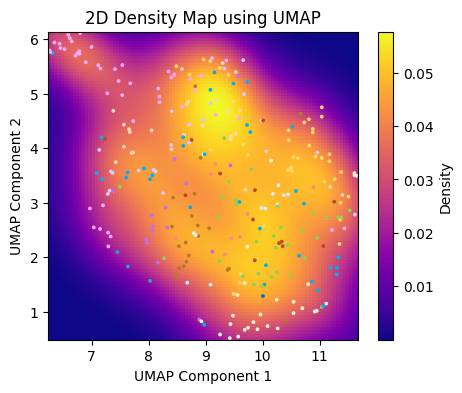

In [6]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

data = np.asarray([glove_model[x] for x in G.nodes()])

umap_model = umap.UMAP(n_components=2)
data_2d = umap_model.fit_transform(data)

# tsne = TSNE(n_components=2)
# data_2d = tsne.fit_transform(data)

# pca = PCA(n_components=2)
# data_2d = pca.fit_transform(data)

x, y = data_2d.T
kde = gaussian_kde(np.vstack([x, y]))
x_grid, y_grid = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
z = kde(np.vstack([x_grid.flatten(), y_grid.flatten()]))

plt.figure(figsize=(5, 4))
plt.pcolormesh(x_grid, y_grid, z.reshape(x_grid.shape), shading='auto', cmap=plt.cm.plasma)
plt.colorbar(label='Density')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D Density Map using UMAP')

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=node_colors, marker='o', label='PCA Points', s=3)
plt.show()

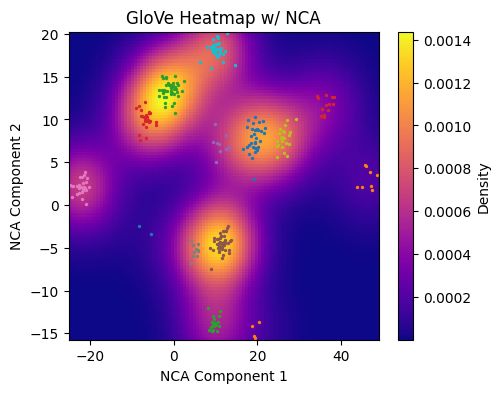

In [7]:
import numpy as np
from sklearn.neighbors import NeighborhoodComponentsAnalysis
import matplotlib.pyplot as plt

excluded_nodes = ['animal', 'yak', 'reindeer', 'seal', 'sealion', 'walrus']

# indices = [n for i, n in enumerate(G.nodes()) if n not in excluded_nodes]
# idx = np.where((data_2d[:, 0] < -60) & (data_2d[:, 1] > 20))
# for i in idx[0]:
#     print(indices[i])

reba_map = {k: i for i, k in enumerate(REBA_CATEGORY_COLORS.keys())}
reba_rev_map = {i: k for i, k in enumerate(REBA_CATEGORY_COLORS.keys())}

data = np.asarray([glove_model[x] for x in G.nodes() if x not in excluded_nodes])
categories = np.asarray([reba_map[reba_adj[x]] if x in reba_adj.keys() else 0 for x in G.nodes() if x not in excluded_nodes])

nca = NeighborhoodComponentsAnalysis(n_components=2)
data_2d = nca.fit_transform(data, categories)

plt.figure(figsize=(5, 4))

x, y = data_2d.T
kde = gaussian_kde(np.vstack([x, y]))
x_grid, y_grid = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
z = kde(np.vstack([x_grid.flatten(), y_grid.flatten()]))

plt.pcolormesh(x_grid, y_grid, z.reshape(x_grid.shape), shading='auto', cmap=plt.cm.plasma)
plt.colorbar(label='Density')
for cat in np.unique(categories):
    plt.scatter(data_2d[categories == cat, 0], data_2d[categories == cat, 1], label=reba_rev_map[cat], s=2)

plt.xlabel('NCA Component 1')
plt.ylabel('NCA Component 2')
plt.title('GloVe Heatmap w/ NCA')
# plt.legend()
plt.show()

## Add Traversal Functions

In [8]:
import random
from src.search import graph_traversal, cue_switch_step, random_walk, random_walk_step, sub_category_switch_step
from src.switch import get_category_transitions

transition_probs = get_category_transitions(hills)
gold = [r['response'] for r in hills]

def traversal_func(graph, sequence, current_node):
    return cue_switch_step(graph, current_node, 1, 5)
cue = graph_traversal(G, traversal_func, traversal_method='max')

def traversal_func(graph, sequence, current_node):
    return sub_category_switch_step(graph, current_node, reba_categories, transition_probs)
sub = graph_traversal(G, traversal_func, traversal_method='max')

def random_func(graph, sequence, current_node):
    return random_walk_step(graph, current_node, 0.01)
sample = graph_traversal(G, random_func, traversal_method='sample', temp=0.3)

rw, _ = random_walk(RW, start_node='dog', max_length=40, max_iter=4000, return_path=True)

human = random.sample(gold, k=1)[0]

runs = {
    'Human Response': human,
    'Greedy Search': cue,
    r'Sampling ($\tau=0.9$)': sample,
    'Random Walk': rw,
}

In [9]:
def segment_path(path, pred, scheme=reba_adj):
    cat = [scheme[r] for r in pred]

    switch, local = [], []
    for i in range(len(cat)):
        if i == 0:
            continue
        if cat[i-1] != cat[i]:
            switch += [[i-1, i]]
        else:
            local += [[i-1, i]]

    print(cat)
    print(local)
    print(switch)

    local = [path[l] for l in local]
    switch = [path[l] for l in switch]
    return local, switch 

['Pets', 'North American', 'Felines', 'Non-Jungle Animals', 'Non-Jungle Animals', 'Felines', 'Non-Jungle Animals', 'Non-Jungle Animals', 'Pets', 'Pets', 'Pets', 'Pets', 'North American', 'Arctic/Far North Animals', 'Fish', 'Fish', 'Fish', 'Pets', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Fish', 'Fish', 'Jungle Animals']
[[3, 4], [6, 7], [8, 9], [9, 10], [10, 11], [14, 15], [15, 16], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [25, 26]]
[[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [7, 8], [11, 12], [12, 13], [13, 14], [16, 17], [17, 18], [24, 25], [26, 27]]
['Primates', 'Pets', 'Pets', 'Pets', 'Pets', 'Pets', 'Pets', 'Pets', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Farm Animals', 'Non-Jungle Animals', 'Felines', 'Felines', 'North American', 'North American', 'North American', 'Insects', 'Insects', 'Insects', 'Jungle Animals', 'Pets', 'Rodent Like', 'Pets', 'Pets', 'Fish', 'Fish', 'Fish', 'Non-Jung

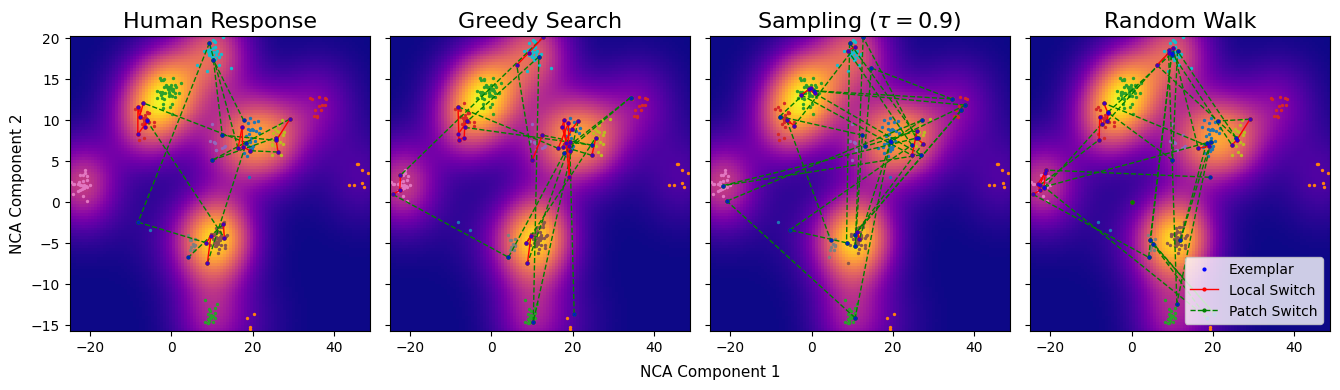

In [16]:
import numpy as np
import matplotlib.pyplot as plt

reba_map = {k: i for i, k in enumerate(REBA_CATEGORY_COLORS.keys())}
reba_rev_map = {i: k for i, k in enumerate(REBA_CATEGORY_COLORS.keys())}
node_map = {k: i for i, k in enumerate(G.nodes()) if k not in excluded_nodes}
node_map = {k: i for i, (k, v) in enumerate(node_map.items())}

# runs['Human Response'] = random.sample(gold, k=1)[0]

# fig, axs = plt.subplots(1, len(runs), figsize=(9, 2.5), sharey=True, sharex=True)
fig, axs = plt.subplots(1, len(runs), figsize=(13.5, 3.75), sharey=True, sharex=True)

for i in range(len(runs)):
    axs[i].pcolormesh(x_grid, y_grid, z.reshape(x_grid.shape), shading='auto', cmap=plt.cm.plasma)
    for cat in np.unique(categories):
        axs[i].scatter(data_2d[categories == cat, 0], data_2d[categories == cat, 1], s=2) # label=reba_rev_map[cat],

for i, (label, pred) in enumerate(runs.items()):
    pred = [n for n in pred if n in node_map.keys()]
    path = data_2d[[node_map[n] for n in pred]]
    local, switch = segment_path(path, pred)

    for p in switch:
        x_line, y_line = zip(*p)
        axs[i].plot(x_line, y_line, marker='o', linestyle='--', markersize=2, color='g', linewidth=1)
    for p in local:
        x_line, y_line = zip(*p)
        axs[i].plot(x_line, y_line, marker='o', linestyle='-', markersize=2, color='r', linewidth=1)
    
    x_line, y_line = zip(*path)
    axs[i].plot(x_line, y_line, marker='o', linestyle=None, markersize=2, color='b', linewidth=0, alpha=0.6)

    axs[i].set_title(label, fontsize=16)

fig.text(0.53, -0.02, 'NCA Component 1', ha='center', fontsize=11)
axs[0].set_ylabel('NCA Component 2', fontsize=11)

axs[axs.shape[0]-1].plot([0, 0], [0, 0], marker='o', linestyle=None, markersize=2, color='b', linewidth=0, label='Exemplar')
axs[axs.shape[0]-1].plot([0, 0], [0, 0], marker='o', linestyle='-', markersize=2, color='r', linewidth=1, label='Local Switch')
axs[axs.shape[0]-1].plot([0, 0], [0, 0], marker='o', linestyle='--', markersize=2, color='g', linewidth=1, label='Patch Switch')
axs[axs.shape[0]-1].legend(loc='lower right')

# axs[0, 1].set_ylabel('Hills Cue Switching', fontsize=11)
# axs[1, 1].set_ylabel('Subcategory Cue', fontsize=11)
# axs[1, 0].set_title('Human Response', fontsize=12)

plt.tight_layout()

out_filename = "img/search_paths.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0, dpi=300)

plt.show()